# 1. Eigene Daten herunterladen und in Google Colab nutzen

1.   Mit Google Account bei [Google Takeout](https://takeout.google.com/) einloggen.
2.   Als Sprache muss Deutsch eingestellt sein. Wie man die Sprache ändert ist [hier](https://support.google.com/accounts/answer/32047) erklärt.
3.   Auf "**Auswahl aufheben**" klicken, denn relevant werden hier nur die Aktivitäten aus der Google Suche sein.
4.   Haken setzen bei "**Meine Aktivitäten**"
5.   Auf "**Alle Aktivitätsdaten eingeschlossen**" klicken
6.   Im aufgehenden Fenster "Optionen für Inhalte in "Meine Aktivitäten"" auf "**Auswahl aufheben**" klicken, dann Haken bei "**Android**" und "**Google Suche**" setzen und unten rechts mit "**OK**" bestätigen.
7.   Ans Seitenende scrollen, auf "**Nächster Schritt**" klicken und dann auf "**Export erstellen**" klicken.
8.   Warten bis der Datenexport von Google erstellt wurde.
9.   Datenexport [hier](https://takeout.google.com/settings/takeout/downloads) herunterladen. Der Dateiname ist ungefär `takeout-20xxxxxxxxxxxxxx-001.zip`.
10.  ZIP-Datei öffnen. In `takeout-20xxxxxxxxxxxxxx-001.zip\Takeout\Meine Aktivitäten\Google Suche\` die Datei `MeineAktivitäten.html` lokalisieren, entpacken und umbenennen in `Suche.html`. In `takeout-20xxxxxxxxxxxxxx-001.zip\Takeout\Meine Aktivitäten\Android\` die Datei `MeineAktivitäten.html` lokalisieren, entpacken und umbenennen in `Android.html`. 
11. Die beiden html-Dateien dann entweder (A) in hiesigen Sitzungsspeicher von Google Colab hochladen oder ins eigene Google Drive hochladen und Google Drive bereitstellen (B). Siehe Screenshot dazu:


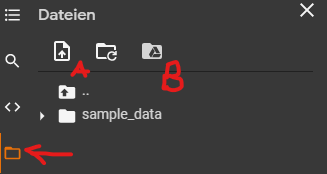

12.  Warten, bis der Upload abgeschlossen ist.
13.  Notebook ausführen (Alles auf einmal ausführen lassen, am einfachsten mit `STRG + F9`)

# 2. Aktivitäten der Google Suche einlesen und aufbereiten
Alle Suchaktivitäten werden zunächst in Listen akkumuliert und dann in Pandas.DataFrame umgewandelt zur weiteren Verarbeitung.

**all_activities** enthält alle Aktivitäten

**searches** enthält alle gesuchten Suchbegriffe

**result_fetches** enthält alle Suchergebnisse, die angeklickt wurden

**viewed** enthält angesehene Orte

**definitions** enthält alle definierten Begriffe

Leider hat Google Bezeichnungen erst im Laufe der Jahre eingeführt oder zuordnungen geändert, weshalb in der Zuordnung Fehler auftreten können. Es hat sich beim Testen herausgestellt, dass ein DataFrame auch komplett leer bleiben kann...

In [ ]:
import sys
import re
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import accuracy_score


files_loaded = False

try:
    search_html_file = open("/content/drive/MyDrive/Suche.html", encoding="utf8")
    android_html_file = open("/content/drive/MyDrive/Android.html", encoding="utf8")
    print("Die erforderlichen html-Dateien wurden in Google Drive gefunden und geladen.")
    files_loaded = True
except:
    print("Die erforderlichen html-Dateien befinden sich nicht in Google Drive oder sind falsch benannt.")
    print("Versuche nach Dateien im Laufzeitspeicher zu suchen...")
try:
    if not files_loaded:
        search_html_file = open("/content/Suche.html", encoding="utf8")
        android_html_file = open("/content/Android.html", encoding="utf8")
        print("Die erforderlichen html-Dateien wurden im Laufzeitspeicher gefunden und geladen.")
        files_loaded = True
except:
    print("Die erforderlichen html-Dateien befinden sich nicht korrekt hochgeladen oder sind falsch benannt.")
 
if not files_loaded:
    print('Die erforderlichen html-Dateien wurden nicht in Google Drive oder im Laufzeitspeicher gefunden.')
    sys.exit()

Wenn die html-Dateien mit den Aktivitäten gefunden und geladen wurden, kann das Analysieren beginnen.

In [6]:
strings_to_remove = ['<div class="outer-cell mdl-cell mdl-cell--12-col mdl-shadow--2dp"><div class="mdl-grid"><div class="header-cell mdl-cell mdl-cell--12-col"><p class="mdl-typography--title">Google Suche<br></p></div><div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1">',
                     '<div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1 mdl-typography--text-right"></div><div class="content-cell mdl-cell mdl-cell--12-col mdl-typography--caption">',
                     '<b>Produkte:</b><br>&emsp;Google Suche',
                     '</div>',
                     '</a>',
                     '<br>',
                     '<b>',
                     '</b>',
                     '<div class="outer-cell mdl-cell mdl-cell--12-col mdl-shadow--2dp"><div class="mdl-grid"><div class="header-cell mdl-cell mdl-cell--12-col"><p class="mdl-typography--title">',
                     '<br></p></div><div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1">',
                     '</div><div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1 mdl-typography--text-right"></div><div class="content-cell mdl-cell mdl-cell--12-col mdl-typography--caption">Produkte:&emsp;Android</div></div></div>']

link_pattern = re.compile('<(.*?)>')
search_term_pattern = re.compile('.+?(?=\sgesucht(0[1-9]|[12][0-9]|3[01])\.(0[1-9]|1[012])\.20[0-2][0-9]\,)')
result_fetch_term_pattern = re.compile('.+?(?=\saufgerufen(0[1-9]|[12][0-9]|3[01])\.(0[1-9]|1[012])\.20[0-2][0-9]\,)')
viewed_term_pattern = re.compile('.+?(?=\sangesehen(0[1-9]|[12][0-9]|3[01])\.(0[1-9]|1[012])\.20[0-2][0-9]\,)')
definition_term_pattern = re.compile('.+?(?=(0[1-9]|[12][0-9]|3[01])\.(0[1-9]|1[012])\.20[0-2][0-9]\,)')
time_format = '%d.%m.%Y, %H:%M:%S'
all_activities = []
searches = []
result_fetches = []
viewed = []
definitions = []

with search_html_file as file:
    raw_data = file.read().replace('\n', '').split(strings_to_remove[0])

for i, e in enumerate(raw_data):
    raw_data[i] = raw_data[i]\
        .replace(strings_to_remove[1], '')\
        .replace(strings_to_remove[2], '')\
        .replace(strings_to_remove[3], '')\
        .replace(strings_to_remove[4], '')\
        .replace(strings_to_remove[5], '')\
        .replace(strings_to_remove[6], '')\
        .replace(strings_to_remove[7], '')
    if raw_data[i][:4] == 'Nach':                                               # handle search terms
        raw_data[i] = re.sub(link_pattern, '', raw_data[i][5:])                 # remove link
        search_term = re.search(search_term_pattern, raw_data[i])[0]
        if 'site:imdb.de' in search_term[-12:]:                                 # exclude searches from stupid browser extension
            continue
        length = len(search_term) + 8                                           # 8 because len(' gesucht') == 8
        raw_data[i] = raw_data[i][length:]                                      # remove search_term from string
        timestamp_str = raw_data[i][:20]                                        # extract timestamp as string
        timestamp = datetime.strptime(timestamp_str, time_format)               # save timestamp as timedate object
        searches.append([search_term, timestamp.year, timestamp.month, timestamp.day, timestamp.hour, timestamp.minute, timestamp.second, timestamp.weekday()])                               # save search result & timestamp to list
        all_activities.append([search_term, timestamp.year, timestamp.month, timestamp.day, timestamp.hour, timestamp.minute, timestamp.second, timestamp.weekday()])                         # save search result & timestamp to list
    if raw_data[i][:9] == 'Definiert':                                          # handle definitions
        raw_data[i] = re.sub(link_pattern, '', raw_data[i][10:])
        definition_term = re.search(definition_term_pattern, raw_data[i])[0]
        raw_data[i] = raw_data[i][len(definition_term):]
        timestamp_str = raw_data[i][:20]
        timestamp = datetime.strptime(timestamp_str, time_format)
        definitions.append([definition_term, timestamp.year, timestamp.month, timestamp.day, timestamp.hour, timestamp.minute, timestamp.second, timestamp.weekday()])
        all_activities.append([definition_term, timestamp.year, timestamp.month, timestamp.day, timestamp.hour, timestamp.minute, timestamp.second, timestamp.weekday()])
    if raw_data[i][:9] == '<a href="':                                          # handle result_fetches
        raw_data[i] = re.sub(link_pattern, '', raw_data[i])                     # remove link
        if raw_data[i][:16] == 'Überwachter Flug':                              # exclude flights
            continue
        if raw_data[i][:17] == 'Aufgerufene Flüge':
            continue
        try:
            result_fetch = re.search(result_fetch_term_pattern, raw_data[i])[0]
            length = len(result_fetch) + 11                                     # 11 because len(' aufgerufen') == 11
            raw_data[i] = raw_data[i][length:]                                  # remove search_term from string
            timestamp_str = raw_data[i][:20]                                    # extract timestamp as string
            timestamp = datetime.strptime(timestamp_str, '%d.%m.%Y, %H:%M:%S')  # save timestamp as timedate object
            result_fetches.append([result_fetch, timestamp.year, timestamp.month, timestamp.day, timestamp.hour, timestamp.minute, timestamp.second, timestamp.weekday()])                    # save result_fetch & timestamp to list
            all_activities.append([result_fetch, timestamp.year, timestamp.month, timestamp.day, timestamp.hour, timestamp.minute, timestamp.second, timestamp.weekday()])                    # save result_fetch & timestamp to list
        except:
            viewed_term = re.search(viewed_term_pattern, raw_data[i])[0]
            length = len(viewed_term) + 10                                      # 10 because len(' angesehen') == 10
            raw_data[i] = raw_data[i][length:]                                  # remove search_term from string
            timestamp_str = raw_data[i][:20]                                    # extract timestamp as string
            timestamp = datetime.strptime(timestamp_str, '%d.%m.%Y, %H:%M:%S')  # save timestamp as timedate object
            viewed.append([result_fetch, timestamp.year, timestamp.month, timestamp.day, timestamp.hour, timestamp.minute, timestamp.second, timestamp.weekday()])                             # save viewed_term & timestamp to list
            all_activities.append([result_fetch, timestamp.year, timestamp.month, timestamp.day, timestamp.hour, timestamp.minute, timestamp.second, timestamp.weekday()])                     # save viewed_term & timestamp to list

all_activities = pd.DataFrame(all_activities, columns=['SearchTerm', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Weekday'])
searches = pd.DataFrame(searches, columns=['SearchTerm', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Weekday'])
result_fetches = pd.DataFrame(result_fetches, columns=['SearchTerm', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Weekday'])
viewed = pd.DataFrame(viewed, columns=['SearchTerm', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Weekday'])
definitions = pd.DataFrame(definitions, columns=['SearchTerm', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Weekday'])

# 3. Daten Analysieren und Visualisieren
Im Folgenden wird visuell aufbereitet, wann Aktivitäten stattfanden.

Anzahl Aktivitäten nach Jahr, Monat, Uhrzeit und Wochentag:

In [ ]:
def count_all_activities(column: str):
    all_activities[column].value_counts().sort_index().plot.bar()
    plt.title('Activities per ' + column)
    plt.xticks(rotation=0)
    plt.show()

count_all_activities('Year')
count_all_activities('Month')
count_all_activities('Hour')
count_all_activities('Weekday')

Im Folgenden lassen sich verschiedene Parameter durch eine Heatmap visuell miteinander kombinieren. So lässt sich z.B. nachvollziehen, an welchem Wochentag zu welchen Uhrzeiten Aktivitäten stattfinden.

In [ ]:
color_palettes = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                  'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                  'GnBu', 'PuBu', 'PuBuGn', 'BuGn']

def compare_dimensions(dataframe, first_column: str, second_column: str):
    if dataframe.shape == (0, 8):   # skip empty dataframes if they occur
        return
    dimensions = [first_column, second_column]
    x = dataframe.copy()
    # drop years with very few and/or vague data
    x = x[x.Year != 2010]
    x = x[x.Year != 2011]
    x = x[x.Year != 2012]
    x = x[x.Year != 2013]
    x = x[x.Year != 2021]     # as 2021 is not over yet, keeping 2021 in the data would distord the result, but you can of course change that
    color_palette = random.choice(color_palettes)
    counts = x.groupby(dimensions).size().unstack(fill_value=0)
    sns.heatmap(counts, cmap=color_palette)
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    plt.show()

compare_dimensions(all_activities, 'Year', 'Month')
compare_dimensions(all_activities, 'Year', 'Hour')
compare_dimensions(all_activities, 'Year', 'Weekday')
compare_dimensions(all_activities, 'Weekday', 'Hour')
compare_dimensions(searches, 'Year', 'Hour')
compare_dimensions(result_fetches, 'Year', 'Hour')
compare_dimensions(viewed, 'Year', 'Hour')
compare_dimensions(definitions, 'Year', 'Hour')

Bis hier wurde ausschließlich mit derm Zeitpunkt der Such-Aktivitäten gearbeitet. Wonach genau gesucht und was geöffnet wurde, ist bisher nicht berücksichtigt worden und trotzdem kann man bereits ungefähr einen Tagesablauf mit z.B. Schlafenszeiten anhand der Daten erkennen. Dies lässt bereits einen kleinen Blick auf das Potenzial in Metadaten erkennen.

# 4. Auftauchen eines speziellen Begriffs zählen

An diesem Beispiel wird gezählt wie oft das Wort "Python" aktiv eingegeben wurden. Der Suchbegriff ist natürlich mit jedem anderen ersetzbar.

In [ ]:
all_activities['SearchTerm'].str.count('python').sum()

Verschiedene Begriffe zählen und die 20 häufigsten anzeigen.

In [ ]:
meaningless_terms = ['-', '–', '—', '...', '|', 'in', 'im', 'of', 'the', 'The',
                     'mit', 'on', 'to', 'für', 'by', 'der', 'die', 'das', 'Der',
                     'Die', 'Das', '&amp;', 'und', 'and', 'von', 'for', 'zu',
                     'den', 'Den', 'a']
words = []
for term in all_activities['SearchTerm']:
    words_in_term = term.split(' ')
    for word in words_in_term:
        words.append(word)
words = pd.DataFrame(words, columns=['SearchTerm'])
for to_exclude in meaningless_terms:
    words = words[words['SearchTerm'] != to_exclude]

words.value_counts().head(20)

# 5. Was lernen wir nun daraus?
Auch ohne in den Inhalt der Suchaktivitäten zu blicken, kann man aus ihrer schieren Masse bereits Schlüsse ziehen. Durch Kombination der Metadaten von sehr vielen Nutzern kann man zu noch weitreichenderen Erkenntnissen gelangen wie z.B. das Verhalten von ganzen Bevölkerungsgruppen analysieren und diese als Zielgruppe für gezielte Werbung ausmachen.

# 6. Android-Aktivitäten einlesen und aufbereiten
Alle Aktivitäten werden zunächst in einer Liste akkumuliert und dann in Pandas.DataFrame umgewandelt zur weiteren Verarbeitung.

In [11]:
app_name_pattern_1 = re.compile('.+?(?=Verwendet)')
app_name_pattern_2 = re.compile('.+?(?=Angesehen)')
timestamp_pattern = re.compile('(0[1-9]|[12][0-9]|3[01])\.(0[1-9]|1[012])\.20[0-2][0-9]\,\s(2[0-3]|[01]?[0-9]):([0-5]?[0-9]):([0-5]?[0-9])')

with android_html_file as file:
    android_data = file.read().replace('\n', '').split(strings_to_remove[8])[2:]

android_activities = []

for i, e in enumerate(android_data):
    android_data[i] = android_data[i]\
        .replace(strings_to_remove[9], '')\
        .replace(strings_to_remove[4], '')\
        .replace(strings_to_remove[5], '')\
        .replace(strings_to_remove[6], '')\
        .replace(strings_to_remove[7], '')\
        .replace(strings_to_remove[10], '')
    try:
        app_name = re.search(app_name_pattern_1, android_data[i])[0]
    except:
        app_name = re.search(app_name_pattern_2, android_data[i])[0]
    timestamp_str = re.search(timestamp_pattern, android_data[i])[0]
    timestamp = datetime.strptime(timestamp_str, time_format)
    android_activities.append([app_name, timestamp.year, timestamp.month, timestamp.day, timestamp.hour, timestamp.minute, timestamp.second, timestamp.weekday()])

android_activities = pd.DataFrame(android_activities, columns=['AppName', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Weekday'])

# 7. Android-Aktivitäten Analysieren und Visualisieren
Im Folgenden wird visuell aufbereitet, wann Android Apps verwendet wurden. Hier lassen sich die Methoden, die auf die Suchaktivitäten angewandt wurden direkt oder mit leichter Anpassung anwenden.

Anzahl Android-Aktivitäten nach Jahr, Monat, Stunde und Wochentag

In [ ]:
def count_android_activities(column: str):
    android_activities[column].value_counts().sort_index().plot.bar()
    plt.title('Android Activities per ' + column)
    plt.xticks(rotation=0)
    plt.show()

count_android_activities('Year')
count_android_activities('Month')
count_android_activities('Hour')
count_android_activities('Weekday')

Heatmaps zur Visualisierung der Verwendung aller Aktivitäten.

In [ ]:
compare_dimensions(android_activities, 'Month', 'Hour')
compare_dimensions(android_activities, 'Weekday', 'Hour')

Heatmaps zur Visualisierung der 50 meistverwendeten Apps in Abhängigkeit von Wochentag und Uhrzeit.

In [ ]:
def compare_dimensions_for_app(dataframe, app_name: str, first_column: str, second_column: str):
    if dataframe.shape == (0, 8):
        return
    dimensions = [first_column, second_column]
    x = dataframe.copy()
    x = x[x.AppName == app_name]
    color_palette = random.choice(color_palettes)
    counts = x.groupby(dimensions).size().unstack(fill_value=0)
    sns.heatmap(counts, cmap=color_palette)
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    plt.title('Usage of ' + app_name)
    plt.show()

#android_activities['AppName'].value_counts()[:3]

for app_name in android_activities['AppName'].value_counts().index[:50]:
    compare_dimensions_for_app(android_activities, app_name, 'Weekday', 'Hour')

# 8. Machine Learning auf Android Aktivitäten anwenden
Im Folgenden wird versucht, ob sich anhand von Jahr, Monat und Sekunde der Woche vorhersagen lässt, welche App verwendet wurde. Warum die Einheit "Sekunde der Woche"? Eigentlich ganz einfach: Damit lässt sich die Woche sinnvoll unterteilen. Wie man in den vorangegangenen Visualisierungen sehen kann, gibt es unterschiede zwischen den Aktivitäten an den einzelnen Wochentagen und Tageszeiten. Dies lässt sich mit "Sekunde der Woche" in einer Dimension zusammenfassen.

In [ ]:
android_activities['SecondOfWeek'] = android_activities['Weekday'] * 86400 + android_activities['Hour'] * 3600 + android_activities['Minute'] * 60 + android_activities['Second']
# create new DataFrame with Learnable Data
learnable_data = android_activities[['AppName', 'Year', 'Month', 'SecondOfWeek']]
# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(learnable_data[['Year', 'Month', 'SecondOfWeek']], learnable_data['AppName'])

app_usage_counts = learnable_data['AppName'].value_counts()
# sort out Apps that are not used often enough to be significant
for app, count in app_usage_counts.iteritems():
    if count < 200:
        learnable_data = learnable_data[learnable_data['AppName'] != app]

# learnable_data.to_csv("learnable_android_data.csv", index = False, encoding='utf-8')  # Die Daten lassen sich bei Bedarf auch als csv-Datei exportieren
print('Anzahl Apps, für die versucht wird, ihre Verwendung vorherzusagen:', learnable_data['AppName'].value_counts().size)

Bei meinem eigenen Datensatz ergab sich mit dem `KNeighborsClassifier` bei 39 Apps eine Genauigkeit von `~0.12`, was beträchtlich mehr als `1/39 (= 0.02564102564)` ist, aber zur verlässlichen Vorhersage taugt das offensichtlich nicht. Dass andere Machine Learning Verfahren deutlich erfolgsversprechender sind, ist nach meiner Einschätzung nicht zu erwarten.

In [ ]:
num_of_apps = learnable_data['AppName'].value_counts().size
knn = neighbors.KNeighborsClassifier(n_neighbors = num_of_apps)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

Auch bei den Android-Aktivitäten kann man aus ihrer schieren Masse bereits Schlüsse ziehen. Beispielsweise lässt sich auf den Heatmaps bzgl. der Häufigkeit der Verwendung einer einzelnen App erkennen, dass einige nur zu bestimmten Tageszeiten verwendet werden, während andere (z.B. WhatsApp bei einem Datensatz) abgesehen von den Schlafzeiten zu allen Tageszeiten verwendet werden.